Hypothesis Testing
==================

Copyright 2016 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy
import scipy.stats

import matplotlib.pyplot as pyplot

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import first

# seed the random number generator so we all get the same results
numpy.random.seed(19)

# some nicer colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'



## Part One

Suppose you observe an apparent difference between two groups and you want to check whether it might be due to chance.

As an example, we'll look at differences between first babies and others.  The `first` module provides code to read data from the National Survey of Family Growth (NSFG).

In [2]:
live, firsts, others = first.MakeFrames()

We'll look at a couple of variables, including pregnancy length and birth weight.  The effect size we'll consider is the difference in the means.

Other examples might include a correlation between variables or a coefficient in a linear regression.  The number that quantifies the size of the effect is called the "test statistic".

In [3]:
def TestStatistic(data):
    group1, group2 = data
    test_stat = abs(group1.mean() - group2.mean())
    return test_stat

For the first example, I extract the pregnancy length for first babies and others.  The results are pandas Series objects.

In [4]:
group1 = firsts.prglngth
group2 = others.prglngth

The actual difference in the means is 0.078 weeks, which is only 13 hours.

In [5]:
actual = TestStatistic((group1, group2))
actual

0.078037266777549519

The null hypothesis is that there is no difference between the groups.  We can model that by forming a pooled sample that includes first babies and others.

In [6]:
n, m = len(group1), len(group2)
pool = numpy.hstack((group1, group2))

Then we can simulate the null hypothesis by shuffling the pool and dividing it into two groups, using the same sizes as the actual sample.

In [7]:
def RunModel():
    numpy.random.shuffle(pool)
    data = pool[:n], pool[n:]
    return data

The result of running the model is two NumPy arrays with the shuffled pregnancy lengths:

In [8]:
RunModel()

(array([36, 40, 39, ..., 43, 42, 40]), array([43, 39, 32, ..., 37, 35, 41]))

Then we compute the same test statistic using the simulated data:

In [9]:
TestStatistic(RunModel())

0.081758440969863955

If we run the model 1000 times and compute the test statistic, we can see how much the test statistic varies under the null hypothesis.

In [10]:
test_stats = numpy.array([TestStatistic(RunModel()) for i in range(1000)])
test_stats.shape

(1000,)

Here's the sampling distribution of the test statistic under the null hypothesis, with the actual difference in means indicated by a gray line.

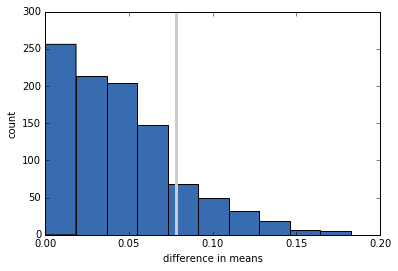

In [15]:
pyplot.vlines(actual, 0, 300, linewidth=3, color='0.8')
pyplot.hist(test_stats, color=COLOR5)
pyplot.xlabel('difference in means')
pyplot.ylabel('count')
None # It's interesting that these None's are significant to the notebook.

The p-value is the probability that the test statistic under the null hypothesis exceeds the actual value.

In [13]:
pvalue = sum(test_stats >= actual) / len(test_stats)
pvalue

0.14999999999999999

In this case the result is about 15%, which means that even if there is no difference between the groups, it is plausible that we could see a sample difference as big as 0.078 weeks.

We conclude that the apparent effect might be due to chance, so we are not confident that it would appear in the general population, or in another sample from the same population.

STOP HERE
---------

Part Two
========

We can take the pieces from the previous section and organize them in a class that represents the structure of a hypothesis test.

In [24]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = numpy.array([self.TestStatistic(self.RunModel()) 
                                       for _ in range(iters)])

        count = sum(self.test_stats >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return max(self.test_stats)

    def PlotHist(self, label=None):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        ys, xs, patches = pyplot.hist(ht.test_stats, color=COLOR4)
        pyplot.vlines(self.actual, 0, max(ys), linewidth=3, color='0.8')
        pyplot.xlabel('test statistic')
        pyplot.ylabel('count')

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()


`HypothesisTest` is an abstract parent class that encodes the template.  Child classes fill in the missing methods.  For example, here's the test from the previous section.

In [25]:
class DiffMeansPermute(HypothesisTest):
    """Tests a difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = numpy.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        numpy.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Now we can run the test by instantiating a DiffMeansPermute object:

In [26]:
data = (firsts.prglngth, others.prglngth)
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
print('\nmeans permute pregnancy length')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())


means permute pregnancy length
p-value = 0.169
actual = 0.07803726677754952
ts max = 0.20696822841


And we can plot the sampling distribution of the test statistic under the null hypothesis.

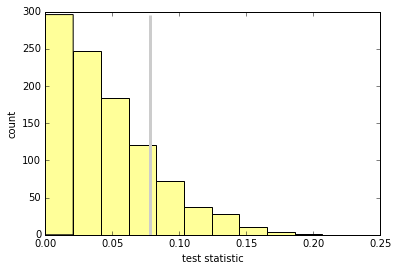

In [27]:
ht.PlotHist()

### Difference in standard deviation

**Exercize 1**: Write a class named `DiffStdPermute` that extends `DiffMeansPermute` and overrides `TestStatistic` to compute the difference in standard deviations.  Is the difference in standard deviations statistically significant?

In [28]:
# Solution goes here

Here's the code to test your solution to the previous exercise.

In [29]:
data = (firsts.prglngth, others.prglngth)
ht = DiffStdPermute(data)
p_value = ht.PValue(iters=1000)
print('\nstd permute pregnancy length')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())


std permute pregnancy length
p-value = 0.156
actual = 0.1760490642294399
ts max = 0.503028294469


### Difference in birth weights

Now let's run DiffMeansPermute again to see if there is a difference in birth weight between first babies and others.

In [30]:
data = (firsts.totalwgt_lb.dropna(), others.totalwgt_lb.dropna())
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
print('\nmeans permute birthweight')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())


means permute birthweight
p-value = 0.0
actual = 0.12476118453549034
ts max = 0.0924976865499


In this case, after 1000 attempts, we never see a sample difference as big as the observed difference, so we conclude that the apparent effect is unlikely under the null hypothesis.  Under normal circumstances, we can also make the inference that the apparent effect is unlikely to be caused by random sampling.

One final note: in this case I would report that the p-value is less than 1/1000 or less than 0.001.  I would not report p=0, because  the apparent effect is not impossible under the null hypothesis; just unlikely.